Functions

In [281]:
#Function to test for stationarity
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

In [282]:
#Function to split dataset based on date selected
def train_test_split(df, enddate_train,startdate_test):
    df_train = df[:enddate_train]
    df_test = df[startdate_test:]
    return df_train, df_test

In [283]:
#Function extract X and Y from dataset ADJUST which X variables we want
def X_Y_transform(df):
    X = df[['Corn Price Futures','OIL_PRICE $/bbl','AVG_TAVG']]
    Y = df['price']
    return X, Y

In [284]:
#Function SARIMAX multi step forecast
def sarimax_forecast(history, future, config, step_size):
    order, sorder, trend = config
    # define model
    X_train,Y_train = X_Y_transform(history)
    X_test,Y_test = X_Y_transform(future)
    model = SARIMAX(endog = Y_train, exog = X_train, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # multistep forecast
    y_hat = model_fit.predict(len(history), (len(history)+step_size-1) , exog=X_test)
    return y_hat

In [285]:
#Function Moving window for univariate data
def moving_window(df, step, cfg):
    print("Fitting the combination", cfg)
    predictions = []
    history_size, step_size = step
    history = df[:history_size]
    future = df[history_size:(history_size+step_size)]

    # step over each time-step in the test set
    for i in range(int(math.ceil((len(df)-history_size)/6))):
        # fit model and make forecast for history
        if len(future) < step_size:
            step_size = len(future)

        yhat = sarimax_forecast(history, future, cfg, step_size)
        # store forecast in list of predictions
        if i == 0:
            predictions = yhat
        else:
            predictions = predictions.append(yhat)
        # move the history and forecast window
        history = history.append(future)
        history = history[step_size:]
        future = df[(history_size+(step_size*(i+1))):(history_size+(step_size*(i+2)))]

    # estimate prediction error
    future = df[history_size:]
    X_test,Y_test = X_Y_transform(future)
    score = evaluation_measures(Y_test, predictions)
    return score, predictions

In [286]:
#Function performance measures
def evaluation_measures(actual, predicted):
    mse = np.square(np.subtract(actual, predicted)).mean()
    return mse

In [299]:
#Function to  create a set of sarima configs to try
def sarima_configs(seasonal=[4]):
    models = list()
    # define config lists
    p_params = [1]
    d_params = [1]
    q_params = [1]
    t_params = ['n','c']
    P_params = [1]
    D_params = [1]
    Q_params = [1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                     for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [288]:
#Function run grid search configs
def grid_search(df, cfg_list, step):
    scores = list()
    filterwarnings("ignore")
    best_score = np.inf
    #best_prediction = list()
    best_cfg = list()

    for cfg in cfg_list:
        score, prediction = moving_window(df, step, cfg)
        scores.append(score)

        if score < best_score:
            print("Found an improved score", score,"is better than", best_score )
            best_score = score
            best_cfg = cfg
            #best_prediction = prediction

    return best_cfg, best_score

In [289]:
#Function take log of price and standardize
def transform_data(df):
    df.price = np.log(df.price)
    scaler = StandardScaler()
    all_cols = list(df.columns)
    scaler.fit(df[all_cols])
    df[all_cols] = scaler.transform(df[all_cols])
    return df

Automatic main code

In [304]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from warnings import filterwarnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [305]:
if __name__ == '__main__':
    #Import data of the required product
    df_maize = pd.read_excel('MAIZE_FILTERED_2023-02-25_19-36-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product

    #Select which country dataset you want to forcast
    #variable_list = list(df_maize.columns.levels[0])
    #country_list = list(df_maize.columns.levels[1])
    country = 'France'
    df = df_maize.xs(country, axis = 1, level =1 , drop_level=True) #ADJUST to country

    #split the data in test and train
    enddate_train = "2022-04-01"
    startdate_test = "2019-11-01"
    df_train_unedited, df_test_unedited = train_test_split(df, enddate_train,startdate_test )

    #take log price and standardize the data
    df_train = transform_data(df_train_unedited)
    df_test = transform_data(df_test_unedited)

    # model configs
    cfg_list = sarima_configs()
    step = [24,6] #history horizon and multistepforecast

    # grid search on train dataset with minimum MSE
    best_cfg, lowest_score = grid_search(df_train, cfg_list,step)
    print('Gridsearch found with best parameters', best_cfg, "with MSE equal to", lowest_score )

Fitting the combination [(1, 1, 1), (1, 1, 1, 4), 'n']
Found an improved score 1.3212412654045265 is better than inf
Fitting the combination [(1, 1, 1), (1, 1, 2, 4), 'n']
Fitting the combination [(1, 1, 1), (1, 1, 1, 4), 'c']
Fitting the combination [(1, 1, 1), (1, 1, 2, 4), 'c']
Gridsearch found with best parameters [(1, 1, 1), (1, 1, 1, 4), 'n'] with MSE equal to 1.3212412654045265


In [306]:
#Run test set
score_test, predictions_test = moving_window(df_test, step, best_cfg)

Fitting the combination [(1, 1, 1), (1, 1, 1, 4), 'n']


In [ ]:
#Export the values
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'{country}_SARIMAXpredictions_{now}.xlsx'
predictions_test.to_excel(filename, index=True)

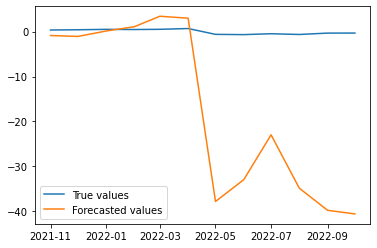

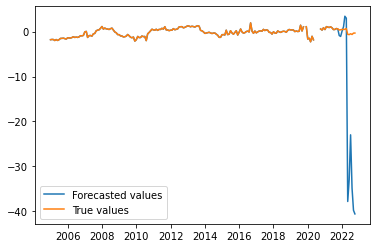

In [307]:
#Visulaize the results

#plot only forcast horizon
plt.plot(df_test.price[step[0]:],label='True values')
plt.plot(predictions_test,label='Forecasted values')
plt.legend()
plt.show()

#plot on full period
trueprices = df.price
forecasted_prices = trueprices[:len(trueprices)-len(predictions_test)]
forecasted_prices = forecasted_prices.append(predictions_test)

plt.plot(forecasted_prices,label='Forecasted values')
plt.plot(trueprices,label='True values')
plt.legend()
plt.show()